In [1]:
#import data
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

BodyParts = pd.read_csv('BodyParts.csv')
DiagnosisCodes = pd.read_csv('DiagnosisCodes.csv')
Disposition = pd.read_csv('Disposition.csv')
data = pd.read_csv('NEISS2014.csv')

/Users/pranjor/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


#### Q1 
What are the top three body parts most frequently represented in this dataset?

In [2]:
top_bp_code = data.body_part.value_counts().head(3)
top_bp_df = pd.DataFrame(top_bp_code)
top_parts = pd.merge(top_bp_df,BodyParts,left_index=True,right_on='Code')
top_parts

,body_part,BodyPart,Code
10,9891,Head,75
6,5786,Face,76
7,5783,Finger,92


What are the top three body parts that are least frequently represented?

In [3]:
bottom_bp_code = data.body_part.value_counts().tail(4)
bottom_bp_df = pd.DataFrame(bottom_bp_code)
bottom_parts = pd.merge(bottom_bp_df,BodyParts,left_index=True,right_on='Code')
bottom_parts

,body_part,BodyPart,Code
11,549,Internal,0
25,390,Not Recorded,87
17,286,Pubic region,38
23,4,25-50% of body,84


Since "Not Recorded" shouldn't count as a body part, the least frequent parts should be internal, public region, and 25%-50% of body.

#### Q2 

How many injuries in this dataset involve a skateboard?
Of those injuries, what percentage were male and what percentage were female?
What was the average age of someone injured in an incident involving a skateboard?

In [4]:
# change the narratives to lower case just in case it's not consistent
narrative_lower = data.narrative.str.lower()
data_lower = data
data_lower.narrative = narrative_lower
skateboard_data = data_lower[data_lower.narrative.str.contains('skateboard')]
skateboard_injury_count = skateboard_data.shape[0]
print "skateboard related injury number: ", skateboard_injury_count

skateboard related injury number:  466


In [5]:
# male percentage
skateboard_male_count = skateboard_data[skateboard_data.sex=='Male'].shape[0]
skateboard_male_per = float(skateboard_male_count)/float(skateboard_injury_count)
print "male percentage: ", "{:.1%}".format(skateboard_male_per)

# female percentage
# I did not use 1-male% to calculate female% because future data might include other genders or no gender
skateboard_female_count = skateboard_data[skateboard_data.sex=='Female'].shape[0]
skateboard_female_per = float(skateboard_female_count)/float(skateboard_injury_count)
print "female percentage: ", "{:.1%}".format(skateboard_female_per)

male percentage:  82.4%
female percentage:  17.6%


In [6]:
# No one was under 2 years old, so no need to convert 200s to years.
skateboard_mean_age = skateboard_data.age.mean()
print "average age: ", round(skateboard_mean_age,2)

average age:  17.99


#### Q3

What diagnosis had the highest hospitalization rate? 
What diagnosis most often concluded with the individual leaving without being seen?
Briefly discuss your findings and any caveats you'd mention when discussing this data

In [7]:
# Assume both 4 and 5 in diposition code count as hospitalization
crosstab = pd.crosstab(data.diag,data.disposition)
crosstab.head()
hospit_rate = (crosstab[4]+crosstab[5])/crosstab.sum(axis=1)
highest_rate_code = hospit_rate.idxmax()
highest_rate_diag = DiagnosisCodes[DiagnosisCodes.Code == highest_rate_code]
print 'highest hospitalization rate:', highest_rate_diag.Diagnosis.values[0]

highest hospitalization rate: Submersion (including Drowning)


In [8]:
# finding most common diagnosis associated with "leaving without being seen"
leaving_diag = crosstab[6].sort_values(ascending=False).head()
leaving_diag

diag
71    257
59    123
62     63
53     52
68     24
Name: 6, dtype: int64

The top code is 71, which is "other". So I have to look into "diag_other" column

In [9]:
leaving_detail = data[(data.disposition == 6) & (data.diag == 71)]
leaving_detail.diag_other.value_counts().head()

PAIN            123
BACK PAIN        10
NO DIAGNOSIS      9
KNEE PAIN         5
N/S               4
Name: diag_other, dtype: int64

The top descriptions in the "diag_other" are more symptoms than diagonsis. So I chose the 2nd most common diagnosis as the final answer.

In [10]:
DiagnosisCodes[DiagnosisCodes.Code == leaving_diag.index[1]]

,Diagnosis,Code
23,Laceration,59


The answer assumes that the records with code 6 represent "leaving without being seen", not "left against medical advice". One thing to do is to cross check with the narratives, but sometimes the narratives don't have all the information.

#### Q4

Visualize any existing relationship between age and reported injuries

In [11]:
# convert records of 200s to years
def convert_age (row):
    if row.age >= 200:
        return (float(row.age)-200)/24
    else:
        return row.age

age_diag = data[['age','diag']]
age_diag = age_diag[age_diag.age <> 0] # drop rows that don't have age
age_diag['new_age'] = age_diag.apply(convert_age, axis=1)

In [12]:
# finding median age for each diagnosis
diag_group = pd.DataFrame({col:vals['new_age'] for col, vals in age_diag.groupby(['diag'])})
med = diag_group.median().sort_values()

ls_age = []
for i in med.index:
    ls_age += [age_diag[age_diag.diag == i].new_age.values]

<function matplotlib.pyplot.show>

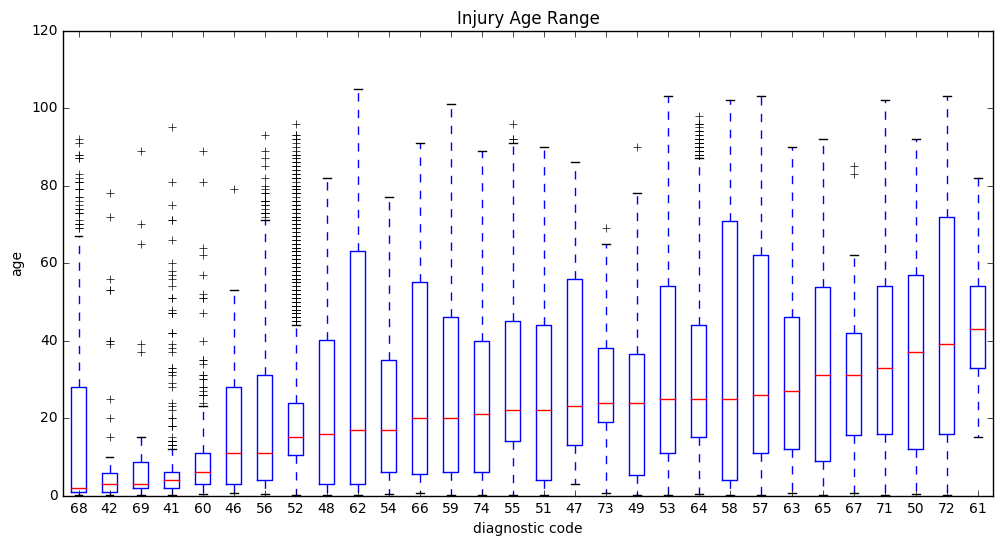

In [13]:
# plotting the relationship
plt.subplots(figsize=(12, 6))
plt.boxplot(ls_age)
plt.xticks(range(1,31),med.index)
plt.ylabel('age')
plt.xlabel('diagnostic code')
plt.title('Injury Age Range')
plt.show

In [14]:
print DiagnosisCodes[(DiagnosisCodes.Code == 61) | (DiagnosisCodes.Code == 42)]

                   Diagnosis  Code
2   Aspirated foreign object    42
24              Nerve damage    61


The chart above is a boxplot of age range of all injuries sorted by median age. Some injuries, such as aspirating foreign object (42), occur more often with children; some injuries, such as nerve damage (61), occur more often with older adults.

#### Q5
Please check indeed Q5.twb in the same folder for details.

The plot below shows that the most common injuries are Laceration (59), Contusions (53), and strain (64). The injuries were more or less evenly represented in all social classes.

<img src="injuries by stratum.png">

The plot below shows that most of the injuries were treated on the spot, with the exception of fracture (57), which has a significant number of hospitalizaton cases. However, this is different from hospitalization rate from Q3.

<img src="injuries by disposition.png">

The plot below shows that the most common injury related products are stairs, flooring, and beds. Naturally, most of these incidents happened at home.

<img src="products by location.png">

The plot below shows that head is the most frequently injured body part by a large margin. Half of that can be attributed to internal organ injury. Lacertaion caused a large number of head injury cases, as well as face (76) and finger (92).

<img src="body parts by injury.png">

The plot below is the age range of each body part. Kids and young adults tend to hurt their mouths(88) and ears(94), and older people tend to hurt their upper trunks(31) and lower trunks(79).

<img src="age range for body parts.png">